In [ ]:
import os

from codecarbon import EmissionsTracker
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from qadence import (
    FeatureParameter,
    RY,
    RZ,
    chain,
    QuantumCircuit,
    Z,
    QNN,
    VariationalParameter,
    CNOT,
)
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_percentage_error as mape
import torch
from torch.utils.data import TensorDataset, DataLoader
import wandb
from wandc.emissions_logger import log_emissions
from qadence.draw import display as g_display
from scipy.optimize import curve_fit

### QNN vs NN on Electricity Grid Data

This notebook is split up into the following sections:

1) Dataset Creation
2) Model Creation
3) Training
4) Classical Comparison

Our data looks like:

```features = [overall_demand, gen_1_price, gen_1_max_power, gen_1_quad_price, ... gen_n]```

```binary targets = [gen_1_active, gen_2_active, gen_3_active, , ... gen_n]```

```X = [25, 8, 15, 6, ... gen_n]```

```y = [1, 0, 1]```

In [ ]:
ds = pd.read_csv("../data/classical_1000_scenarios_gens_3.csv")
display(ds)

### 1) Dataset Creation

In [2]:
def load_full_ds():
    ds = pd.read_csv("../data/classical_1000_scenarios_gens_3.csv")
    ds = ds.drop(columns=["scenario", "Unnamed: 0"])
    ds = ds.sample(frac=1)
    print(ds.shape)
    num_gens = [col for col in ds.columns if "solution_gen" in col]
    target_cols = [f"solution_gen_{i}" for i in range(len(num_gens))]
    feat_cols = [col for col in ds.columns if col not in target_cols]
    X, y = ds[feat_cols].to_numpy() * 1.0, ds[target_cols].to_numpy() * 1.0
    return X, y, feat_cols, target_cols


def create_dummy_ds():
    X = torch.randint(0, 2, (1000, 3), dtype=torch.float64)
    y = (X.sum(dim=1) * 1.0).unsqueeze(1)

    print(f"Sample from X: {X[:1]}", f"Sample from y: {y[:1]}")
    return (
        X,
        y,
    )


dummy = False

if not dummy:
    X, y, feat_cols, target_cols = load_full_ds()
    print(f"X: {X.shape}, y: {y.shape}")
else:
    X, y = create_dummy_ds()
    print(f"X: {X.shape}, y: {y.shape}")

NUM_FEATURES = X.shape[1]
NUM_SCENARIOS = X.shape[0]
NUM_TARGETS = y.shape[1]  # TODO: reduce number of generators

print(f"Num targs: {NUM_TARGETS}")


def preprocessing(dataset: np.array):
    from sklearn.preprocessing import MinMaxScaler, StandardScaler

    standard_scale = False

    if standard_scale:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(dataset)
    else:
        scaler = MinMaxScaler(feature_range=(0, 1))
        X_scaled = scaler.fit_transform(dataset)
    return X_scaled


if not dummy:
    X = preprocessing(X)


def prepare_dataset_and_loaders(X, y, train_split=0.7, batch_size=1):
    train_inputs, train_outputs = (
        X[: int(train_split * len(X))],
        y[: int(train_split * len(y))],
    )
    val_inputs, val_outputs = (
        X[int(train_split * len(X)) :],
        y[int(train_split * len(y)) :],
    )
    print(train_inputs, train_outputs)
    train_dataset = TensorDataset(
        torch.tensor(train_inputs), torch.tensor(train_outputs)
    )
    validation_dataset = TensorDataset(
        torch.tensor(val_inputs), torch.tensor(val_outputs)
    )
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(validation_dataset)
    return train_loader, val_loader

dummy = False
train_loader, val_loader = prepare_dataset_and_loaders(X, y, batch_size=32)

(1000, 13)
X: (1000, 10), y: (1000, 3)
Num targs: 3
[[0.47945205 0.77777778 0.11111111 ... 1.         0.33333333 1.        ]
 [0.09589041 0.44444444 0.88888889 ... 0.11111111 0.33333333 0.37931034]
 [0.63013699 0.77777778 0.77777778 ... 0.22222222 0.88888889 0.62068966]
 ...
 [0.21917808 0.44444444 0.11111111 ... 0.22222222 0.88888889 0.        ]
 [0.16438356 0.11111111 0.22222222 ... 0.         1.         0.55172414]
 [0.49315068 0.33333333 0.66666667 ... 0.11111111 0.11111111 0.37931034]] [[12. 13.  9.]
 [ 0.  5.  2.]
 [25.  3. 19.]
 ...
 [10.  5.  1.]
 [ 4.  1.  6.]
 [10. 14. 12.]]


### 2) QNN Model Construction

In [22]:
# Make Feature block
def build_model(num_layers: int = 3, num_qubits: int = 10, dummy=False):

    def _make_feature_block():
        feature_params = [FeatureParameter(f"feature_{i}") for i in range(NUM_FEATURES)]

        blocks = []

        for feat_idx, feat in enumerate(feature_params):
            # Convert a real feature value into a qubit angle, encoding it into quantum state.
            qubit_idx = feat_idx % num_qubits
            blocks.append(RY(qubit_idx, feat))

        feature_block = chain(*blocks)
        return feature_block

    feature_block = _make_feature_block()

    # Make Ansatz Block

    # check QNN vs NN param count
    # TODO: explore HEA (Qadence docs)

    def _build_one_layer(layer_idx: int):
        subblocks_for_one_layer = []

        for i in range(num_qubits):
            alpha1 = VariationalParameter(
                f"alpha_1_{i}_{layer_idx}", init_value=np.random.uniform(-0.05, 0.05)
            )
            beta1 = VariationalParameter(
                f"beta_1_{i}_{layer_idx}", init_value=np.random.uniform(-0.05, 0.05)
            )
            kappa1 = VariationalParameter(
                f"kappa_1_{i}_{layer_idx}", init_value=np.random.uniform(-0.05, 0.05)
            )
            delta1 = VariationalParameter(
                f"delta_1_{i}_{layer_idx}", init_value=np.random.uniform(-0.05, 0.05)
            )

            subblocks_for_one_layer.append(
                chain(
                    CNOT(
                        i, (i + 1) % num_qubits
                    ),  # TODO: explore different order of CNOT and RY
                    RY(i, alpha1),
                    RZ(i, kappa1),
                    CNOT((i + 1) % num_qubits, i),
                    RY(i, beta1),
                    RZ(i, delta1),
                )
            )

        layer = chain(*subblocks_for_one_layer)
        return layer

    def _construct_ansatz_component(num_layers: int):
        layers = [_build_one_layer(i) for i in range(num_layers)]
        return chain(*layers)

    ansatz_block = _construct_ansatz_component(num_layers)

    # Combine Feature and Ansataz block and create model.
    full_block = chain(feature_block, ansatz_block, feature_block, ansatz_block)
    circuit = QuantumCircuit(num_qubits, full_block)
    inputs = [f"feature_{i}" for i in range(NUM_FEATURES)]

    # Encode array of scalar values that will act as our target.
    #
    # Try out multiplying the observable to increase the range of the achievable predictions.
    #
    multiplier = True

    if dummy:
        observable = sum(Z(i) for i in range(num_qubits))
    else:
        if multiplier:
            params = [
                VariationalParameter(f"scale_obs_{i}") for i in range(NUM_TARGETS)
            ]
            observable = [
                param * Z(i) for (param, i) in zip(params, range(NUM_TARGETS))
            ]

            # observable looks like [a0 * Z(0), a1 * Z(1), a2 * Z(0)]
        else:
            a1 = VariationalParameter("scale_obs_1")
            observable = [a1 * Z(i) for i in range(NUM_TARGETS)]

    qnn = QNN(circuit, observable, inputs=inputs)

    display(f"QNN trainable params: {qnn.num_vparams}")
    return qnn

qnn = build_model(num_layers=5, num_qubits=12, dummy=False)

'QNN trainable params: 243'

### 3) Model Training

In [5]:
def train(model, epochs=10, num_layers=8, num_qubits=8, name="qnn"):

    model.train()

    loss_function = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=4e-2)

    performance = []
    total_emissions = 0

    wandb_id = wandb.util.generate_id()
    wandb.init(
        project="pasqal-challenge",
        id=wandb_id,
        name=f"{name}_{num_qubits}_qubits_{num_layers}_layers",
    )
    tracker = EmissionsTracker(allow_multiple_runs=True, log_level="critical")

    for epoch in range(epochs):
        tracker.start()
        total_loss = 0
        for i, (x_batch, y_batch) in enumerate(train_loader):

            if i > 10:
                continue

            # QNN expects x_batch shape [batch_size, NUM_FEATURES]
            y_pred = model(x_batch)

            # Target shape is [batch_size, NUM_TARGETS]
            loss = loss_function(y_pred, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += float(loss)
        total_loss = total_loss / len(train_loader)
        performance.append(total_loss)
        print(f"Epoch {epoch}, Loss: {total_loss:.4f}")
        total_emissions += tracker.stop()
        wandb.log({"train_loss": total_loss, "emissions": total_emissions})

    wandb.finish()

    return model, performance, total_emissions


qnn = build_model(num_layers=5, num_qubits=4)
# model, losses, emissions = train(qnn, epochs=10, num_qubits=12)

In [6]:
qnn = build_model(num_layers=25, num_qubits=6)
model, losses, emissions = train(qnn, epochs=2)

wandb: Currently logged in as: d_smit to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


[codecarbon WARNING @ 20:36:04] Multiple instances of codecarbon are allowed to run at the same time.


Epoch 0, Loss: 48.3661
Epoch 1, Loss: 44.0771


emissions,▁█
train_loss,█▁
emissions,4e-05
train_loss,44.07709


In [7]:
from sklearn.metrics import mean_absolute_error

def eval_model(model, name="qnn_12"):
    model.eval()
    preds = []
    actuals = []
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            preds_out = model(x_batch)
            preds.append(preds_out[0].numpy())
            actuals.append(y_batch[0].numpy())

    preds_concat = np.concatenate(preds, axis=0)
    actuals_concat = np.concatenate(actuals, axis=0)
    print(preds_concat[:2], actuals_concat[:2])
    mape_val = mape(preds_concat, actuals_concat)
    mae = mean_absolute_error(preds_concat, actuals_concat)

    print(f"MAPE: {mape_val}")

    return {"name": name, "mape": round(mape_val, 3), "mae" : round(mae, 3)}


perf_dict = eval_model(qnn)
print(perf_dict)

[0.80874642 1.15710327] [9. 5.]
MAPE: 6.2000930025394885
{'name': 'qnn_12', 'mape': 6.2, 'mae': 6.377}


In [ ]:
for name, param in qnn.named_parameters():
    if param.grad is not None:
        print(name, param.grad.norm().item())

In [ ]:
def plot_training_performance(losses: list[float], y_lim=0.8, title=""):
    # losses = [loss.item() for loss in losses]
    fig = plt.figure(figsize=(8, 6))
    plt.rcParams["lines.markersize"] = 1
    plt.plot(losses, marker="o", label="Loss")
    plt.ylim(0, y_lim)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f" {title} Training Loss Over {len(losses)} Epochs")
    plt.grid(True)
    plt.legend()
    plt.show()


plot_training_performance(losses, title="QNN", y_lim=100)

In [ ]:
qnn = build_model(num_layers=5, num_qubits=12)

In [8]:
from qadence.draw import display as g_display

g_display(qnn)

ValueError: Cannot visualize QuantumModel with more than one observable.

In [18]:
num_qubits=12
qnn = build_model(num_layers=5, num_qubits=12)
qnn_model, losses, emissions = train(
    model=qnn, epochs=50, num_qubits=num_qubits, num_layers=5
)
perf = eval_model(qnn_model)
perf["loss"] = losses
perf["emissions"] = emissions
with open(f"{num_qubits}_qnn.json", "w") as f:
    import json
    json.dump(perf, f)

In [19]:
def one_run(num_qubits=8, epochs=3):
    qnn = build_model(num_layers=5, num_qubits=num_qubits)
    qnn_model, losses, emissions = train(
        model=qnn, epochs=epochs, num_qubits=num_qubits, num_layers=5
    )
    perf = eval_model(qnn_model)
    perf["loss"] = losses
    perf["emissions"] = emissions
    return perf


experiment = {}
qubits = [12, 4, 8, 10]
for qubit in qubits:
    perf = one_run(num_qubits=qubit, epochs=50)
    with open(f"{qubit}_qnn.json", "w") as f:
        import json
        json.dump(perf, f)
    experiment[f"{qubit}_qubits"] = perf

display(experiment)

Epoch 0, Loss: 52.2158
Epoch 1, Loss: 46.5610
Epoch 2, Loss: 43.1749
Epoch 3, Loss: 39.5252
Epoch 4, Loss: 37.4492
Epoch 5, Loss: 31.7367
Epoch 6, Loss: 35.4406
Epoch 7, Loss: 30.2654
Epoch 8, Loss: 31.7357
Epoch 9, Loss: 28.4060
Epoch 10, Loss: 26.8809
Epoch 11, Loss: 26.7283
Epoch 12, Loss: 24.2546
Epoch 13, Loss: 25.4832
Epoch 14, Loss: 24.3132
Epoch 15, Loss: 21.9750
Epoch 16, Loss: 22.4395
Epoch 17, Loss: 24.0590
Epoch 18, Loss: 22.5319
Epoch 19, Loss: 20.9194
Epoch 20, Loss: 20.4784
Epoch 21, Loss: 19.9856
Epoch 22, Loss: 19.8193
Epoch 23, Loss: 20.6450
Epoch 24, Loss: 21.5133
Epoch 25, Loss: 19.5985
Epoch 26, Loss: 20.9856
Epoch 27, Loss: 18.5631
Epoch 28, Loss: 19.1969
Epoch 29, Loss: 18.7793
Epoch 30, Loss: 17.5911
Epoch 31, Loss: 18.3725
Epoch 32, Loss: 18.3338
Epoch 33, Loss: 16.6502
Epoch 34, Loss: 15.8779
Epoch 35, Loss: 17.4103
Epoch 36, Loss: 15.1959
Epoch 37, Loss: 14.9794
Epoch 38, Loss: 15.1292
Epoch 39, Loss: 14.3961
Epoch 40, Loss: 13.4550
Epoch 41, Loss: 15.0370
Ep

emissions,▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇█
train_loss,█▇▆▆▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▃▂▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁
emissions,0.08759
train_loss,12.22765


[7.23998503 6.13246384] [9. 5.]
MAPE: 0.5786401478023864


Epoch 0, Loss: 50.8920
Epoch 1, Loss: 49.0184
Epoch 2, Loss: 43.6991
Epoch 3, Loss: 42.7110
Epoch 4, Loss: 41.6795
Epoch 5, Loss: 36.1426
Epoch 6, Loss: 35.3781
Epoch 7, Loss: 29.9064
Epoch 8, Loss: 31.2056
Epoch 9, Loss: 29.5585
Epoch 10, Loss: 26.2436
Epoch 11, Loss: 29.3646
Epoch 12, Loss: 25.0626
Epoch 13, Loss: 24.9523
Epoch 14, Loss: 26.4885
Epoch 15, Loss: 24.1147
Epoch 16, Loss: 23.8735
Epoch 17, Loss: 23.4332
Epoch 18, Loss: 24.4718
Epoch 19, Loss: 22.3369
Epoch 20, Loss: 23.9194
Epoch 21, Loss: 23.4756
Epoch 22, Loss: 22.2461
Epoch 23, Loss: 21.9627
Epoch 24, Loss: 24.1571
Epoch 25, Loss: 22.5217
Epoch 26, Loss: 21.0021
Epoch 27, Loss: 21.7358
Epoch 28, Loss: 19.7346
Epoch 29, Loss: 19.0444
Epoch 30, Loss: 22.8050
Epoch 31, Loss: 20.0955
Epoch 32, Loss: 22.1735
Epoch 33, Loss: 20.1629
Epoch 34, Loss: 20.5334
Epoch 35, Loss: 21.2852
Epoch 36, Loss: 20.4279
Epoch 37, Loss: 20.9895
Epoch 38, Loss: 19.7337
Epoch 39, Loss: 19.5952
Epoch 40, Loss: 18.2696
Epoch 41, Loss: 19.2066
Ep

emissions,▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇█
train_loss,██▆▆▅▃▄▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▂▂▁▁▁▁▁▁▁▂▁
emissions,0.00216
train_loss,20.36424


[10.67960723  8.79189126] [9. 5.]
MAPE: 1.0700230181609365


Epoch 0, Loss: 49.5214
Epoch 1, Loss: 48.6757
Epoch 2, Loss: 47.7184
Epoch 3, Loss: 42.8273
Epoch 4, Loss: 42.0997
Epoch 5, Loss: 37.2617
Epoch 6, Loss: 35.9887
Epoch 7, Loss: 32.6182
Epoch 8, Loss: 32.4096
Epoch 9, Loss: 31.1167
Epoch 10, Loss: 29.2912
Epoch 11, Loss: 27.9747
Epoch 12, Loss: 26.5303
Epoch 13, Loss: 28.9973
Epoch 14, Loss: 25.9838
Epoch 15, Loss: 25.2342
Epoch 16, Loss: 25.3127
Epoch 17, Loss: 25.4688
Epoch 18, Loss: 25.3024
Epoch 19, Loss: 22.5460
Epoch 20, Loss: 21.9807
Epoch 21, Loss: 23.3668
Epoch 22, Loss: 20.6735
Epoch 23, Loss: 21.9643
Epoch 24, Loss: 21.0269
Epoch 25, Loss: 20.5785
Epoch 26, Loss: 20.8015
Epoch 27, Loss: 21.8424
Epoch 28, Loss: 21.7538
Epoch 29, Loss: 19.1266
Epoch 30, Loss: 20.7490
Epoch 31, Loss: 18.9835
Epoch 32, Loss: 20.8470
Epoch 33, Loss: 19.8459
Epoch 34, Loss: 19.2603
Epoch 35, Loss: 21.2061
Epoch 36, Loss: 18.1263
Epoch 37, Loss: 19.0078
Epoch 38, Loss: 18.3582
Epoch 39, Loss: 17.0653
Epoch 40, Loss: 18.1173
Epoch 41, Loss: 18.9770
Ep

emissions,▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇█
train_loss,███▇▆▅▄▄▄▄▃▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▂▁▁▁▁
emissions,0.0095
train_loss,17.53562


[10.59520569  7.88539208] [9. 5.]
MAPE: 0.6398422061239651


Epoch 0, Loss: 50.4278
Epoch 1, Loss: 46.3920
Epoch 2, Loss: 44.7780
Epoch 3, Loss: 40.7100
Epoch 4, Loss: 38.2667
Epoch 5, Loss: 37.5672
Epoch 6, Loss: 33.9678
Epoch 7, Loss: 31.4005
Epoch 8, Loss: 28.8552
Epoch 9, Loss: 32.8093
Epoch 10, Loss: 28.2005
Epoch 11, Loss: 27.9129
Epoch 12, Loss: 25.2045
Epoch 13, Loss: 26.6646
Epoch 14, Loss: 24.7305
Epoch 15, Loss: 23.0436
Epoch 16, Loss: 24.5007
Epoch 17, Loss: 23.0385
Epoch 18, Loss: 21.7868
Epoch 19, Loss: 21.7307
Epoch 20, Loss: 19.9978
Epoch 21, Loss: 22.4646
Epoch 22, Loss: 21.5517
Epoch 23, Loss: 21.2047
Epoch 24, Loss: 20.5908
Epoch 25, Loss: 20.7205
Epoch 26, Loss: 20.9659
Epoch 27, Loss: 20.8215
Epoch 28, Loss: 19.1094
Epoch 29, Loss: 19.9725
Epoch 30, Loss: 20.6076
Epoch 31, Loss: 21.1688
Epoch 32, Loss: 20.1541
Epoch 33, Loss: 19.3698
Epoch 34, Loss: 19.4032
Epoch 35, Loss: 18.3316
Epoch 36, Loss: 18.0645
Epoch 37, Loss: 18.8709
Epoch 38, Loss: 18.4723
Epoch 39, Loss: 16.1616
Epoch 40, Loss: 17.9921
Epoch 41, Loss: 16.8551
Ep

emissions,▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇█
train_loss,██▇▆▆▅▄▅▄▄▄▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁
emissions,0.02181
train_loss,15.88025


[9.80948428 6.8747956 ] [9. 5.]
MAPE: 0.6214287287087503


{'12_qubits': {'name': 'qnn_12',
  'mape': 0.579,
  'mae': 3.657,
  'loss': [52.21581479859117,
   46.56104137906445,
   43.17489878217029,
   39.525163715179445,
   37.44923351922419,
   31.73671988075786,
   35.44057557835311,
   30.26535884633023,
   31.73572700025325,
   28.405988583654768,
   26.880910507550684,
   26.72831750109425,
   24.254586823573504,
   25.483186126579934,
   24.313236256254413,
   21.974974476462737,
   22.43948869716633,
   24.05899593906512,
   22.53189410109361,
   20.919405300643763,
   20.478366000589265,
   19.985573712014233,
   19.81926321872946,
   20.644983959134397,
   21.513317470855466,
   19.598507396709863,
   20.985632034222625,
   18.56309243289617,
   19.19688405723216,
   18.7793418824093,
   17.59107122673479,
   18.372494034685523,
   18.333794336497917,
   16.65024291467701,
   15.877857642138947,
   17.4103470533463,
   15.195853740289529,
   14.979402346865186,
   15.129242078222397,
   14.396062818018201,
   13.454992508900556,
   1

In [ ]:
perf

In [ ]:
with open("experiment_results_1.json", "wb") as f:
    import json
    json.dump(experiment, f)

### 4) Classical Comparison 

In [88]:
import torch.nn as nn
import torch.nn.functional as F


class SimpleMLP(nn.Module):
    def __init__(self, in_features, hidden_dim=4, out_features=9):
        """
        Basic MLP for comparison with a QNN:
          - input -> hidden_dim -> ReLU -> out_features
        """
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, out_features)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [90]:
nn_model = SimpleMLP(in_features=NUM_FEATURES, hidden_dim=20, out_features=NUM_TARGETS)
total_params = sum(p.numel() for p in nn_model.parameters() if p.requires_grad)
print("Number of MLP trainable parameters:", total_params)
model_classical, losses_classical, _ = train(nn_model, epochs=50)

Number of MLP trainable parameters: 283


Epoch 0, Loss: 34.1932
Epoch 1, Loss: 23.3965
Epoch 2, Loss: 18.9873
Epoch 3, Loss: 14.3114
Epoch 4, Loss: 12.8413
Epoch 5, Loss: 10.4934
Epoch 6, Loss: 8.5939
Epoch 7, Loss: 7.7496
Epoch 8, Loss: 6.1796
Epoch 9, Loss: 5.7064
Epoch 10, Loss: 4.9396
Epoch 11, Loss: 4.8654
Epoch 12, Loss: 4.3202
Epoch 13, Loss: 3.6469
Epoch 14, Loss: 3.8821
Epoch 15, Loss: 3.8543
Epoch 16, Loss: 3.7126
Epoch 17, Loss: 3.2977
Epoch 18, Loss: 3.3356
Epoch 19, Loss: 3.4092
Epoch 20, Loss: 3.3531
Epoch 21, Loss: 2.8727
Epoch 22, Loss: 2.9361
Epoch 23, Loss: 3.2614
Epoch 24, Loss: 3.1625
Epoch 25, Loss: 3.1678
Epoch 26, Loss: 2.6685
Epoch 27, Loss: 2.8361
Epoch 28, Loss: 2.8965
Epoch 29, Loss: 2.5791
Epoch 30, Loss: 2.6157
Epoch 31, Loss: 2.7178
Epoch 32, Loss: 2.4089
Epoch 33, Loss: 2.5985
Epoch 34, Loss: 2.5265
Epoch 35, Loss: 2.2935
Epoch 36, Loss: 2.3980
Epoch 37, Loss: 2.2316
Epoch 38, Loss: 2.1754
Epoch 39, Loss: 2.3169
Epoch 40, Loss: 2.2398
Epoch 41, Loss: 2.0294
Epoch 42, Loss: 2.1561
Epoch 43, Loss:

emissions,▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇█
train_loss,█▆▅▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
emissions,0.0003
train_loss,1.79888


In [ ]:
for dim in [10, 20, 30, 45]:
    nn_model = SimpleMLP(
        in_features=NUM_FEATURES, hidden_dim=dim, out_features=NUM_TARGETS
    )
    total_params = sum(p.numel() for p in nn_model.parameters() if p.requires_grad)
    print("Number of MLP trainable parameters:", total_params)
    model_classical, losses_classical, emissions = train(
        nn_model, epochs=100, name="nn", num_qubits=total_params
    )

In [ ]:
plot_training_performance(losses_classical, title="Classical")

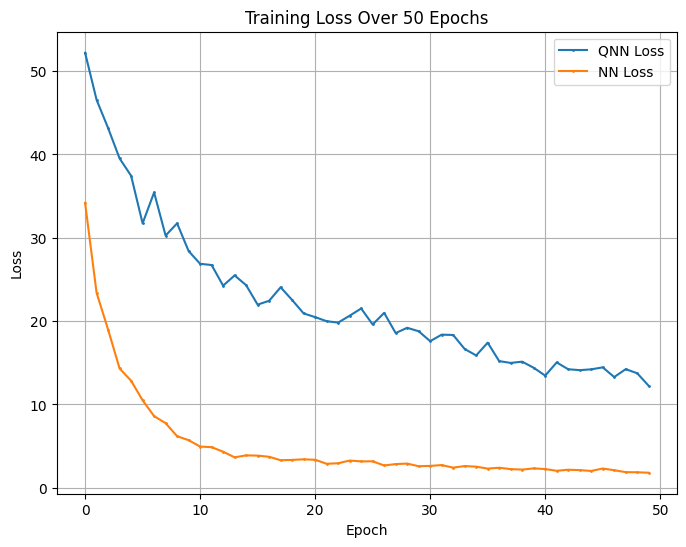

In [91]:
def plot_both(losses: list[list[float]]):
    # Get floats from tensor objects.
    _ = plt.figure(figsize=(8, 6))
    qnn_losses, nn_losses = losses
    plt.rcParams["lines.markersize"] = 1
    plt.plot(qnn_losses, marker="o", label="QNN Loss")
    plt.plot(nn_losses, marker="o", label="NN Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Training Loss Over {len(losses[0])} Epochs")
    plt.grid(True)
    plt.legend()
    plt.show()


plot_both([experiment["12_qubits"]["loss"], losses_classical])

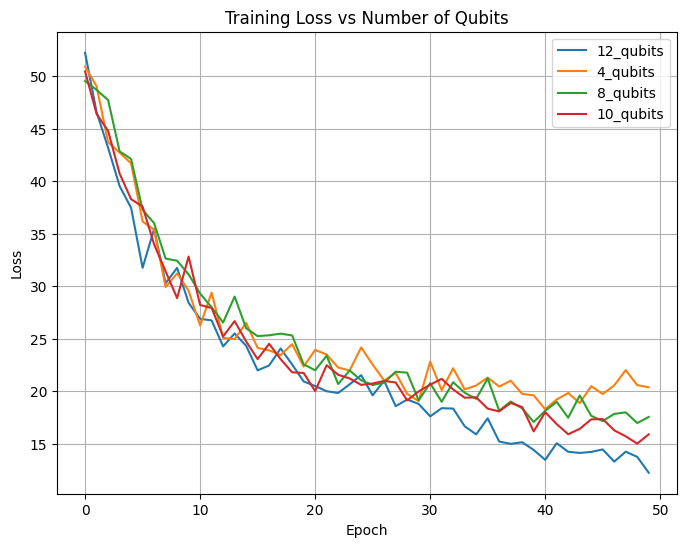

In [79]:
def plot_all(experiment_data: dict):
    _ = plt.figure(figsize=(8, 6))
    plt.rcParams["lines.markersize"] = 1
    runs = experiment_data.keys()
    for run in runs:
        final_mape = experiment_data[run]["mape"]
        loss = experiment_data[run]["loss"]
        plt.plot(loss, label=run)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss vs Number of Qubits")
    plt.grid(True)
    plt.legend()
    plt.show()


plot_all(experiment)

In [102]:
experiment

{'12_qubits': {'name': 'qnn_12',
  'mape': 0.579,
  'mae': 3.657,
  'loss': [52.21581479859117,
   46.56104137906445,
   43.17489878217029,
   39.525163715179445,
   37.44923351922419,
   31.73671988075786,
   35.44057557835311,
   30.26535884633023,
   31.73572700025325,
   28.405988583654768,
   26.880910507550684,
   26.72831750109425,
   24.254586823573504,
   25.483186126579934,
   24.313236256254413,
   21.974974476462737,
   22.43948869716633,
   24.05899593906512,
   22.53189410109361,
   20.919405300643763,
   20.478366000589265,
   19.985573712014233,
   19.81926321872946,
   20.644983959134397,
   21.513317470855466,
   19.598507396709863,
   20.985632034222625,
   18.56309243289617,
   19.19688405723216,
   18.7793418824093,
   17.59107122673479,
   18.372494034685523,
   18.333794336497917,
   16.65024291467701,
   15.877857642138947,
   17.4103470533463,
   15.195853740289529,
   14.979402346865186,
   15.129242078222397,
   14.396062818018201,
   13.454992508900556,
   1

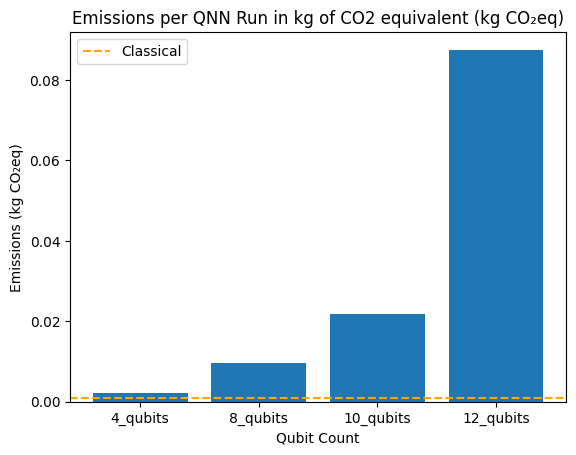

In [112]:
def plot_emissions(experiment_data: dict):
    runs = list(experiment_data.keys())
    maximum_observed_classical_co2_from_wandb = 0.001
    emissions = [experiment_data[run]["emissions"] for run in runs]

    emissions = emissions[1:] + [emissions[0]]  # bad code but we ran out of time   
    runs = runs[1:] + [runs[0]] 

    plt.bar(runs, emissions)
    plt.axhline(y=maximum_observed_classical_co2_from_wandb, color='orange', linestyle='--', label='Classical')
    plt.legend()
    plt.xlabel("Qubit Count")
    plt.ylabel("Emissions (kg CO₂eq)")
    plt.title("Emissions per QNN Run in kg of CO2 equivalent (kg CO₂eq)")

    plt.show()


plot_emissions(experiment)

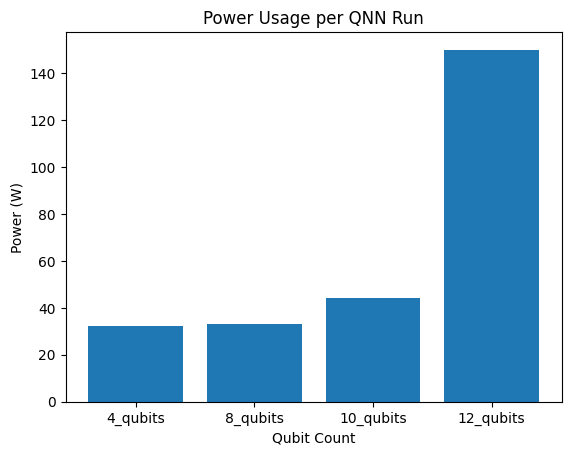

In [81]:
power_data_from_wandb = {
    "4_qubits": 32,
    "8_qubits": 33,
    "10_qubits": 44,
    "12_qubits": 150,
}


def plot_energy_usage(experiment_data: dict):
    runs = list(experiment_data.keys())
    energy_usage = experiment_data.values()

    plt.bar(runs, energy_usage)
    plt.xlabel("Qubit Count")
    plt.ylabel("Power (W)")
    plt.title("Power Usage per QNN Run")

    # Display the plot
    plt.show()


plot_energy_usage(power_data_from_wandb)

Fitted a=0.0000, b=5.4753, c=0.0316


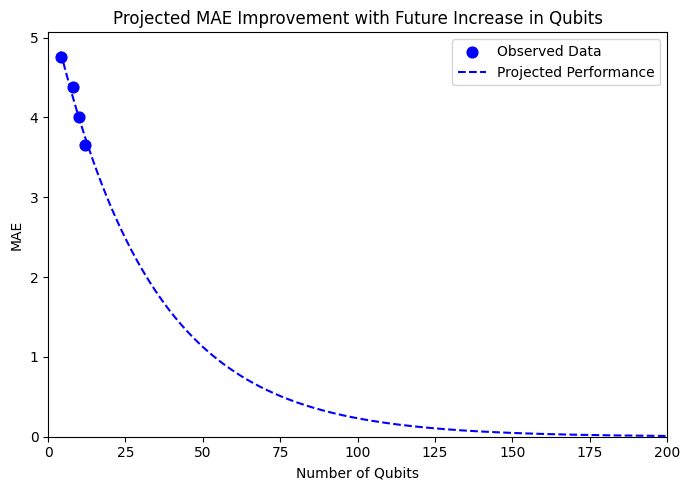

In [83]:
def plot_projected_perf(experiment_data: dict):

    run_data = experiment.values()

    x_qubits = np.array([4, 8, 10, 12], dtype=float)
    y_mae = np.array(sorted([run["mae"] for run in run_data], reverse=True), dtype=float)


    def positive_exp_decay(x, log_a, log_b, log_c):
        a = np.exp(log_a)
        b = np.exp(log_b)
        c = np.exp(log_c)
        return a + b * np.exp(-c * x)

    p0 = [np.log(0.5), np.log(0.2), np.log(0.1)]
    params, cov = curve_fit(positive_exp_decay, x_qubits, y_mae, p0=p0)

    log_a_fit, log_b_fit, log_c_fit = params
    a_fit = np.exp(log_a_fit)
    b_fit = np.exp(log_b_fit)
    c_fit = np.exp(log_c_fit)

    print(f"Fitted a={a_fit:.4f}, b={b_fit:.4f}, c={c_fit:.4f}")

    x_range = np.linspace(x_qubits.min(), 200, 300)
    y_fit   = positive_exp_decay(x_range, log_a_fit, log_b_fit, log_c_fit)

    plt.figure(figsize=(7,5))

    plt.scatter(x_qubits, y_mae, color='blue', marker='o', s=60,
                label='Observed Data')

    plt.plot(x_range, y_fit, color='blue', linestyle='--',
            label='Projected Performance')

    plt.xlim(0, 200)
    plt.ylim(bottom=0)
    plt.xlabel('Number of Qubits')
    plt.ylabel('MAE')
    plt.title('Projected MAE Improvement with Future Increase in Qubits')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_projected_perf(experiment_data=experiment)